In [1]:
import pandas as pd
import nltk
#nltk.download()
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt

In [2]:
# Import Data
vdata = pd.read_csv('Videos_data.csv')
vdata.head(10)

,Unnamed: 0,Video Id,Title,Description,Category
0,0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,3,#NAME?,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel
5,5,yvn79Rv0F48,Backpacking In Meghalaya | NorthEast India Tri...,"In this video I explored North East India, sta...",travel
6,6,SL_YBLWdZb8,Welcome to Peru! | Best Essential Tips &amp; T...,Welcome to Peru! This essential travel guide w...,travel
7,7,kiNyRY5s7n8,How to Start a Travel Blog [2019] Travel Blogg...,Create a Travel Blog Website for Just $3.95 + ...,travel
8,8,kY41XgTEEQU,A Day with KSRTC Bus Fans - Aanavandi Travel B...,ആനവണ്ടി ഭ്രാന്തൻമാരോടൊപ്പം കുമളിയിൽ ഒരു ദിവസം ...,travel
9,9,7mIzRYh8jGA,What is it like to travel in PAKISTAN?,Subscribe now: https://goo.gl/6zXZGK Watch the...,travel


In [3]:
data = vdata.drop(['Unnamed: 0'], axis = 1)

data.isnull().sum()

Video Id         0
Title            0
Description    334
Category         0
dtype: int64

In [4]:
print(data.shape)
data = data.dropna(how='any')
print(data.shape)

(10333, 4)
(9999, 4)


In [5]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [6]:
stop_words = set(stopwords.words('english'))
##Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine"]
stop_words = list(stop_words.union(new_words))

In [7]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in stop_words]

    # remove words less than three letters
    text = [word for word in text if len(word) >= 3]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word, "v") for word in text]
    
    return ' '.join(text)

In [8]:
# The frac keyword argument specifies the fraction of rows to return in the random sample
# specifying drop=True prevents .reset_index from creating a column containing the old index entries.
data = data.sample(frac=1).reset_index(drop=True)
docs = pd.DataFrame()
docs['Title'] = data['Title'].iloc[:5000].apply(lambda x:pre_process(x))
docs['Description'] = data['Description'].iloc[:5000].apply(lambda x:pre_process(x))

In [9]:
docs.head()

,Title,Description
0,alex vizorek parler art,alex vizorek parler art youtube https www yout...
1,cook persian rice,welcome henrys howtos fulltime self train exec...
2,americans try australian snack,subscribe new videos every weekly live stream ...
3,ilang mga travel tip ibinahagi travel blogger ...,isa janeena chan mga online influencer lifesty...
4,louis vuitton art pack,pack favorite louis vuitton bag expert tip see...


In [10]:
# Label encoding the classes

docs['classes'] = data['Category']
docs['classes'].value_counts()

classes
food                      879
manufacturing             850
art and music             841
travel                    811
science and technology    810
history                   809
Name: count, dtype: int64

In [11]:
# Encode classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(docs['classes'])
docs['classes'] = le.transform(docs['classes'])
docs.head()

,Title,Description,classes
0,alex vizorek parler art,alex vizorek parler art youtube https www yout...,0
1,cook persian rice,welcome henrys howtos fulltime self train exec...,1
2,americans try australian snack,subscribe new videos every weekly live stream ...,1
3,ilang mga travel tip ibinahagi travel blogger ...,isa janeena chan mga online influencer lifesty...,5
4,louis vuitton art pack,pack favorite louis vuitton bag expert tip see...,0


In [12]:
le.classes_
# art and music -> 0, food -> 1, and so on.

array(['art and music', 'food', 'history', 'manufacturing',
       'science and technology', 'travel'], dtype=object)

In [13]:
docs['classes'].value_counts()

classes
1    879
3    850
0    841
5    811
4    810
2    809
Name: count, dtype: int64

In [14]:
# Vectorizing text features using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_title = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf_desc = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
labels = docs['classes']
features_title = tfidf_title.fit_transform(docs['Title']).toarray()
features_description = tfidf_desc.fit_transform(docs['Description']).toarray()
print('Title Features Shape: ' + str(features_title.shape))
print('Description Features Shape: ' + str(features_description.shape))

Title Features Shape: (5000, 1270)
Description Features Shape: (5000, 2654)


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100

# Combining titles and descriptions into a single sentence
titles = docs['Title'].values
descriptions = docs['Description'].values
data_for_lstms = []
for i in range(len(titles)):
    temp_list = [titles[i], descriptions[i]]
    data_for_lstms.append(' '.join(temp_list))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_for_lstms)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(data_for_lstms)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

# One-hot Encode labels
Y = pd.get_dummies(docs['classes']).values
print('Shape of label tensor:', Y.shape)

# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

<>:23: SyntaxWarning: invalid escape sequence '\]'
<>:23: SyntaxWarning: invalid escape sequence '\]'
C:\Users\Ganesh\AppData\Local\Temp\ipykernel_2116\3820067558.py:23: SyntaxWarning: invalid escape sequence '\]'
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)


Found 16298 unique tokens.
Shape of data tensor: (5000, 50)
Shape of label tensor: (5000, 6)


In [16]:
titles[0:4]

array(['alex vizorek parler art', 'cook persian rice',
       'americans try australian snack',
       'ilang mga travel tip ibinahagi travel blogger janeena chan'],
      dtype=object)

In [17]:
data_for_lstms[0:4]

['alex vizorek parler art alex vizorek parler art youtube https www youtube com user festivalduriretv facebook https www facebook com montreux comedy festival',
 'cook persian rice welcome henrys howtos fulltime self train executive chef well alot experience knowledge diy electronics trade',
 'americans try australian snack subscribe new videos every weekly live stream website http bite gottlovemerch like support channel directly help',
 'ilang mga travel tip ibinahagi travel blogger janeena chan isa janeena chan mga online influencer lifestyle blogger kinikilala henerasyon ngayon bilang isang travel bloggers madam din syang']

In [18]:
# Define LSTM Model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

c:\Users\Ganesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# Training LSTM Model
epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2462 - loss: 1.7764 - val_accuracy: 0.5960 - val_loss: 1.6317
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6040 - loss: 1.4341 - val_accuracy: 0.8840 - val_loss: 0.7636
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8812 - loss: 0.5513 - val_accuracy: 0.9573 - val_loss: 0.2475
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9644 - loss: 0.1672 - val_accuracy: 0.9707 - val_loss: 0.1584
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9837 - loss: 0.0844 - val_accuracy: 0.9693 - val_loss: 0.1430
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9923 - loss: 0.0484 - val_accuracy: 0.9707 - val_loss: 0.1340
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9954 - loss: 0.0242 - val_accuracy: 0.9693 - val_loss: 0.1435
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9928 - loss: 0.0425 - val_accuracy: 0.9613 - v

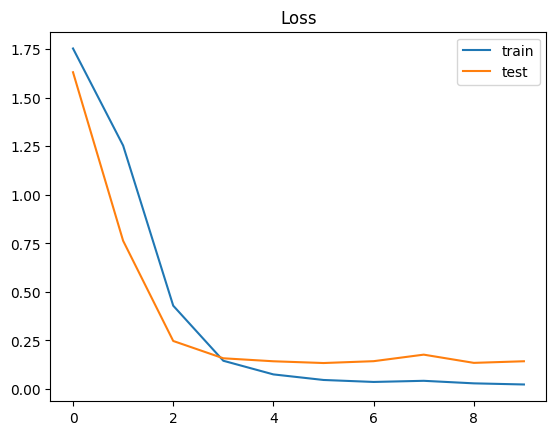

In [20]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

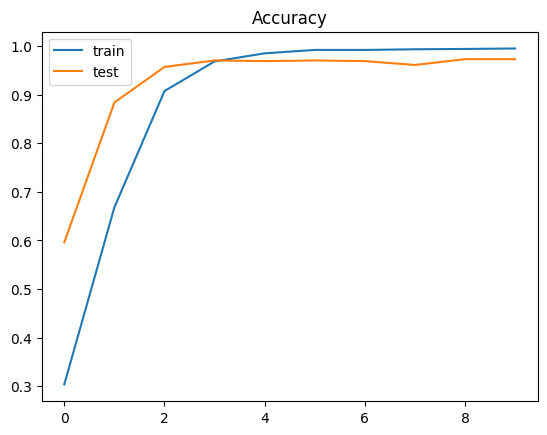

In [21]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [22]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(tokenizer, open('video_classification-tokenizer.pkl', 'wb'))
model.save('video_classification-model.h5')